In [1]:
#!/usr/bin/env python3
import os
import json
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

from src.architecture import FootpathModelArchitecture
from src.miscellaneous import load_random_image, preprocess_image
from src.training_preparation import (create_checkpoint_callback,
                                      create_training_dataset, load_image_test,
                                      load_image_train, load_vgg16_weights,
                                      map_to_masks, sum_up_training_dataset,
                                      sum_up_validation_dataset)
from src.visualization import create_overlay, display_images
from src.transfer_learning_preparation import freeze_layers

## Load and prepare parameters

In [2]:
parameter_directory = './parameters/'
transfer_learning_parameter_file = 'transfer_learning.json'
parameter_path = parameter_directory + transfer_learning_parameter_file

In [3]:
with open(parameter_path) as parameter_file:
    transfer_learning_parameters = json.load(parameter_file)

In [4]:
initial_parameters = transfer_learning_parameters['initial']
data_parameters = transfer_learning_parameters['data']
input_parameters = transfer_learning_parameters['input']
compiler_parameters = transfer_learning_parameters['compiler']
solver_parameters = transfer_learning_parameters['solver']
output_parameters = transfer_learning_parameters['output']
testing_parameters = transfer_learning_parameters['testing']

In [5]:
NUMBER_OF_TRAINING_IMAGES = len(os.listdir(data_parameters['training_data_directory'] +
                                           data_parameters['training_image_folder']))
NUMBER_OF_VALIDATION_IMAGES = len(os.listdir(data_parameters['training_data_directory'] +
                                             data_parameters['validation_image_folder']))

In [6]:
BUFFER_SIZE = NUMBER_OF_TRAINING_IMAGES + 1
TRAINING_STEPS = NUMBER_OF_TRAINING_IMAGES
VALIDATION_STEPS = NUMBER_OF_VALIDATION_IMAGES
SAVE_CHECKPOINT_STEPS = NUMBER_OF_TRAINING_IMAGES * solver_parameters['save_checkpoints_steps']

## Build the model structure and load weights

In [72]:
input_shape = (input_parameters['width'], input_parameters['height'], input_parameters['channels'])

In [73]:
footpath_model = FootpathModelArchitecture(input_shape).footpath_model

In [74]:
if (initial_parameters['format'] == 'h5'):
    footpath_model.load_weights(initial_parameters['intial_weight_path'])

## Prepare the training data

In [7]:
training_data = create_training_dataset(data_parameters['training_data_directory'])

In [8]:
training_set = training_data['training']
training_set = training_set.map(lambda training_set: load_image_train(training_set,
                                                                      (input_parameters['width'],
                                                                       input_parameters['height'])))
validation_set = training_data['validation']
validation_set = validation_set.map(lambda validation_set: load_image_test(validation_set,
                                                                           (input_parameters['width'],
                                                                            input_parameters['height'])))

In [9]:
training_set = sum_up_training_dataset(training_set, buffer_size=BUFFER_SIZE,
                                       batch_size=solver_parameters['batch_size'])

In [10]:
validation_set = sum_up_validation_dataset(validation_set, 
                                           batch_size=solver_parameters['batch_size'])

### Show samples of training and validation data

(1, 485, 882, 1)


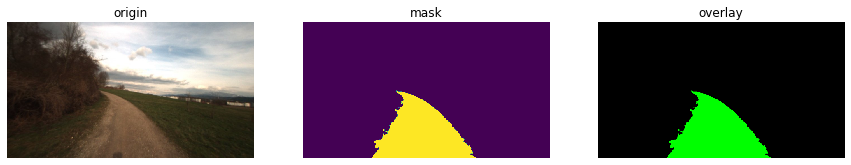

In [11]:
for _, sample in enumerate(training_set.take(1)):
    original_image = sample[0]
    mask = sample[1]
    print(mask.shape)
    overlay = create_overlay(original_image, mask)
    display_images([original_image, mask, overlay], ['origin', 'mask', 'overlay'])

In [89]:
image = training_set.take(1)

In [90]:
image

<TakeDataset shapes: ((None, 485, 882, 3), (None, 485, 882, 1)), types: (tf.float32, tf.float32)>

TypeError: float() argument must be a string or a number, not 'TakeDataset'

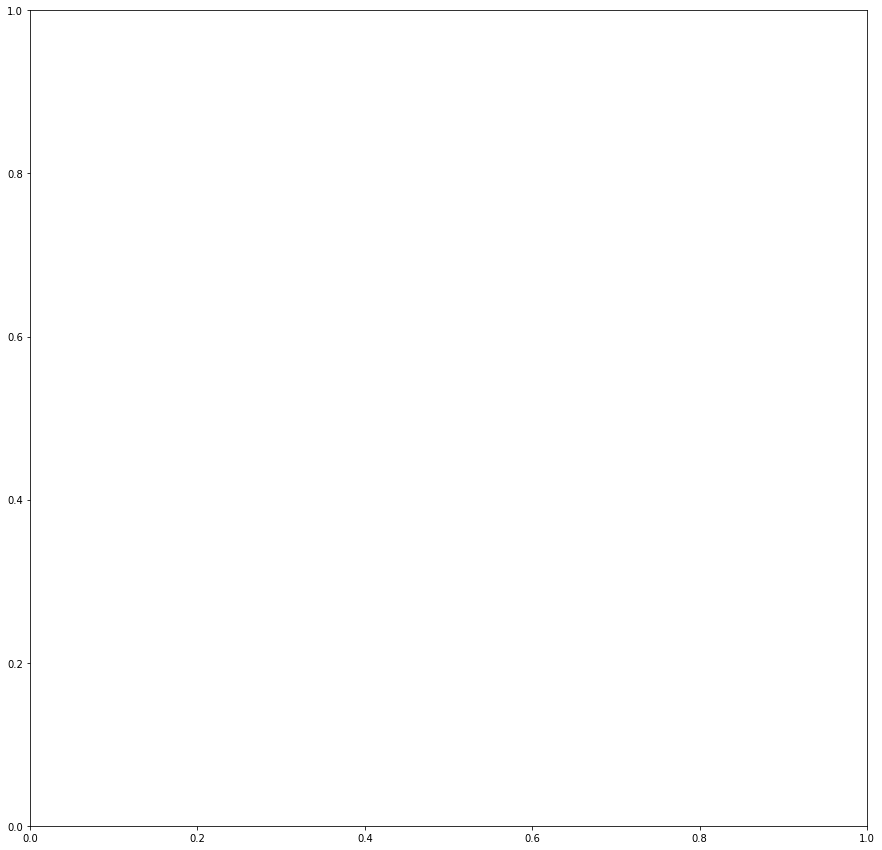

In [86]:
display_images([image], [''])

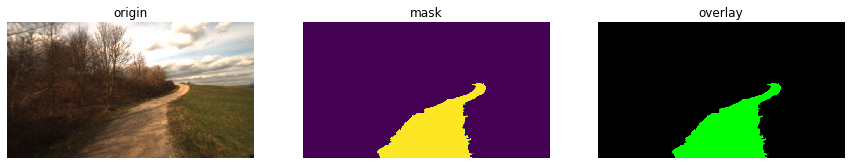

In [12]:
for _, sample in enumerate(validation_set.take(1)):
    original_image = sample[0]
    mask = sample[1]
    
    overlay = create_overlay(original_image, mask)
    display_images([original_image, mask, overlay], ['origin', 'mask', 'overlay'])

## Define callbacks

In [13]:
log_directory = (output_parameters['output_folder'] +
                 output_parameters['log_folder'] +
                 datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_directory)

In [14]:
checkpoint_directory = (output_parameters['output_folder'] + output_parameters['checkpoint_folder'])
checkpoint_callback = create_checkpoint_callback(checkpoint_directory,
                                                 save_best_only=True,
                                                 monitor='binary_crossentropy',
                                                 save_weights_only=True,
                                                 save_freq=SAVE_CHECKPOINT_STEPS)

In [15]:
limit = solver_parameters['epochs'] - (solver_parameters['epochs'] // 3)
adjusted_learning_rate = 0.005

In [16]:
def scheduler(epoch, initial_learning_rate, limit, adjusted_learning_rate):
    if (limit == 0):
        return initial_learning_rate
    elif (epoch < limit):
        return initial_learning_rate
    else:
        return adjusted_learning_rate

In [18]:
learning_rate_callback = LearningRateScheduler(lambda epoch: scheduler(epoch, 
                                                                       compiler_parameters['learning_rate'], 
                                                                       limit, 
                                                                       adjusted_learning_rate))

## Freeze layers 

In [75]:
freeze_layers(footpath_model, initial_parameters['freezed_layers'])

In [76]:
# Show which layers remain trainable
for layer in footpath_model.layers:
    if (layer.trainable):
        print(layer.name)

upscore32
cropping2d_2
final_conv


## Compile and train the model

In [77]:
footpath_model.compile(optimizer=Adam(learning_rate=compiler_parameters['learning_rate'],
                                      epsilon=compiler_parameters['epsilon']),
                       loss=BinaryCrossentropy(from_logits=False),
                       metrics=[tf.keras.metrics.BinaryCrossentropy()])

In [78]:
model_history = footpath_model.fit(training_set,
                                   epochs=solver_parameters['epochs'],
                                   steps_per_epoch=TRAINING_STEPS,
                                   validation_steps=VALIDATION_STEPS,
                                   validation_data=validation_set,
                                   callbacks=[checkpoint_callback, tensorboard_callback, learning_rate_callback])

Train for 214 steps, validate for 60 steps
Epoch 1/35
 61/214 [=======>......................] - ETA: 23:42 - loss: 1.4033 - binary_crossentropy: 1.4014

KeyboardInterrupt: 

In [44]:
for layer in footpath_model.layers[:-1]:
    layer.trainable = False